In [18]:
# Install necessary packages
%pip install imbalanced-learn
%pip install xgboost
%pip install scikit-optimize
%pip install scikit-learn

In [19]:
# @title Imports and Dependencies
import sys
import io
import os
import time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from skopt import BayesSearchCV
from skopt.space import Real
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

if not os.path.exists('Image'):
    os.makedirs('Image')

In [ ]:
from IPython.display import display, Markdown

class ColabAndFileLogger:
    def __init__(self, filename):
        self.filename = filename
        self.log_file = open(filename, 'w', encoding='utf-8')
        self.buffer = io.StringIO()
        self.original_stdout = sys.stdout

    def write(self, message):

        self.log_file.write(message)
        self.buffer.write(message)
        try:
            self.original_stdout.write(message)
            self.original_stdout.flush()
        except Exception as e:
            print(f"DEBUG: Error writing to original stdout: {e}")

    def flush(self):
        self.log_file.flush()
        self.original_stdout.flush()

    def close(self):
        self.log_file.close()

output_file_path = 'lung_cancer_prediction_output.txt'
logger = ColabAndFileLogger(output_file_path)
sys.stdout = logger
print("✅ Logger activated.")


start_time = time.time()
print("--- Starting execution time measurement ---")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
# @title Data Loading
print("--- Attempting to load the dataset ---")

file_path_local = 'lung_cancer_prediction_dataset.csv'
file_path_drive = '/content/drive/MyDrive/ITCS 3156/Datasets/lung_cancer_prediction_dataset.csv'
local_download_path = '/content/lung_cancer_prediction_dataset.csv'
try:
    print(f"Attempting to load from local path: {file_path_local}")
    df = pd.read_csv(file_path_local)
    print("Dataset loaded successfully from local path.")
except FileNotFoundError:
    print(f"Local file not found at '{file_path_local}'. Attempting to load from Google Drive.")
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print(f"Attempting to load from Google Drive path: {file_path_drive}")
        df = pd.read_csv(file_path_drive)
        print("Dataset loaded successfully from Google Drive.")

        print(f"Downloading dataset from Google Drive to {local_download_path}")
        df.to_csv(local_download_path, index=False)
        print("Dataset downloaded to local environment.")

    except FileNotFoundError:
        print(f"Error: Dataset file not found at '{file_path_drive}' on Google Drive. Please ensure the file exists.")
        sys.exit(1)
    except Exception as e:
        print(f"An unexpected error occurred during Google Drive loading: {e}")
        sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred during local file loading: {e}")
    sys.exit(1)

print(f"\nProceeding with a DataFrame of shape: {df.shape}")

In [22]:
# @title and Sampling Configuration
# Use a sample of the dataset
use_sample = False #@param {type:"boolean"}

# Target size of the sample
target_sample_size = 10000 #@param {type:"number"}

# Use a random sample (if False, will use the first N rows)
use_random_sample = False #@param {type:"boolean"}

print("\n--- Dataset Size Selection ---")
original_shape = df.shape[0]
if use_sample and original_shape > target_sample_size:
    if use_random_sample:
        # Create a random sample
        df = df.sample(n=target_sample_size, random_state=42).copy()
        print(f"Selected to use a RANDOM sample of {target_sample_size} rows from the original {original_shape}.")
    else:
        # Use the first N rows
        df = df.head(target_sample_size).copy()
        print(f"Selected to use the FIRST {target_sample_size} rows from the original {original_shape}.")
elif use_sample and original_shape <= target_sample_size:
    print(f"Original dataset has {original_shape} samples, which is less than or equal to the target sample size of {target_sample_size}. Proceeding with the full dataset.")
else:
    print(f"Selected to use the FULL original dataset. Current dataset size: {original_shape} rows.")

print(f"\nProceeding with a DataFrame of shape: {df.shape}")

In [23]:
# @title Data Inspection
print("\n--- Initial Data Inspection ---")
print("Dataset Shape:", df.shape)

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nDescriptive Statistics for Numerical Features:")
print(df.describe())

In [24]:
# @title Data Cleaning
print("\n--- Columns Cleaning ---")
df.columns = df.columns.str.replace(' ', '_').str.replace('.', '', regex=False).str.replace('/', '_').str.replace('-', '_').str.lower()
print("\n--- Columns after initial cleaning ---")
print(df.columns.tolist())

print("\n--- Initial Missing Values Check ---")
print(df.isnull().sum())

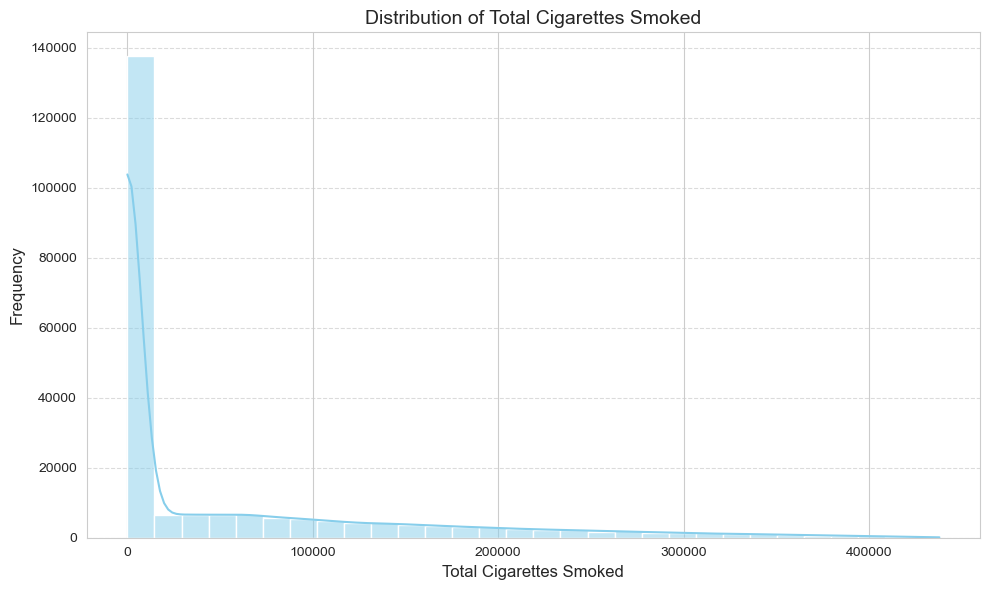

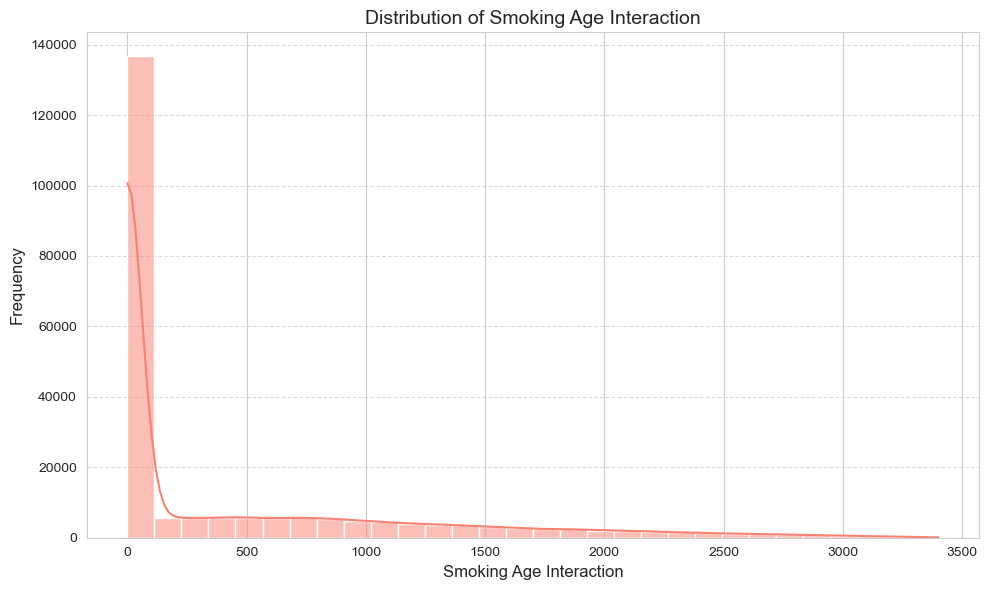

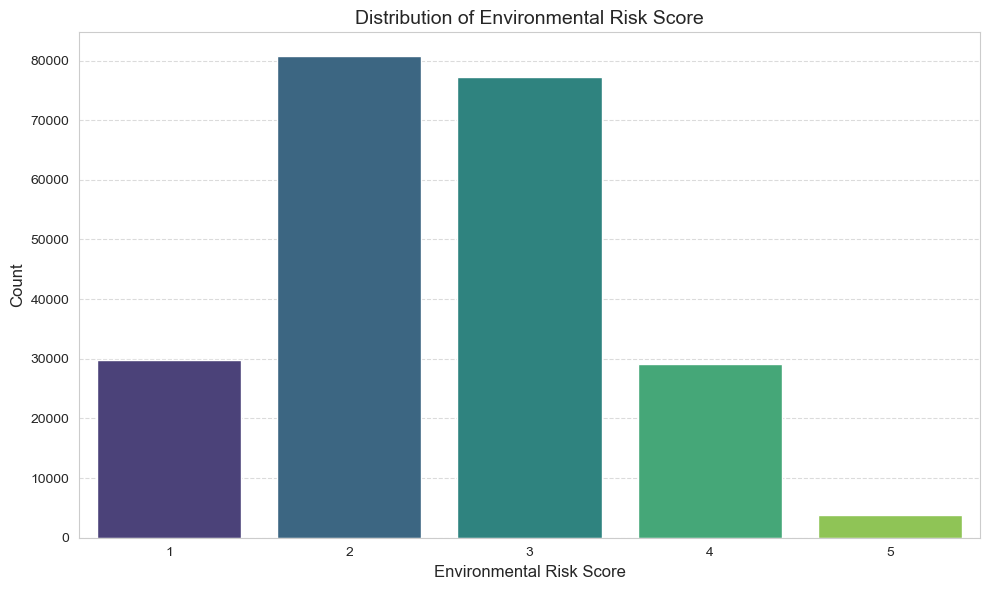

In [25]:
# @title Data Analysis / Feature Selection & Preprocessing

# Columns to drop with high missing values or uneeded values
cols_to_drop = ['cancer_stage', 'treatment_type']

# Dropping these columns from the DataFrame with error handling
df_processed = df.drop(columns=cols_to_drop, errors='ignore')
print(f"\nDropped columns: {cols_to_drop}")
print("New Dataset Shape:", df_processed.shape)

print("\n--- Missing Values Check After Dropping Columns ---")
print(df_processed.isnull().sum())

cols_to_drop_further = ['id', 'country', 'population_size', 'annual_lung_cancer_deaths', 'lung_cancer_prevalence_rate', 'mortality_rate', 'survival_years', 'developed_or_developing']

df_processed = df_processed.drop(columns=cols_to_drop_further, errors='ignore')
print(f"\nFurther dropped columns: {cols_to_drop_further}")
print("New Dataset Shape after feature selection:", df_processed.shape)
print("\nRemaining columns:", df_processed.columns.tolist())

# --- New Feature Engineering ---
print("\n--- Starting New Feature Engineering ---")

# 1. Total Cumulative Smoking Exposure
# Interaction term between years of smoking and daily cigarette consumption.
df_processed['total_cigarettes_smoked'] = df_processed['years_of_smoking'] * df_processed['cigarettes_per_day'] * 365

# 2. Smoking Age Interaction
# Combined effect of age and years of smoking.
df_processed['smoking_age_interaction'] = df_processed['age'] * df_processed['years_of_smoking']

# 3. Environmental Risk Score
# Combines various exposure risks into a single score.
df_processed['air_pollution_exposure_num'] = df_processed['air_pollution_exposure'].map({'Low': 1, 'Medium': 2, 'High': 3})
df_processed['occupational_exposure_num'] = df_processed['occupational_exposure'].map({'No': 0, 'Yes': 1})
df_processed['indoor_pollution_num'] = df_processed['indoor_pollution'].map({'No': 0, 'Yes': 1})

df_processed['environmental_risk_score'] = df_processed['air_pollution_exposure_num'] + df_processed['occupational_exposure_num'] + df_processed['indoor_pollution_num']

# Separate target variable first
X = df_processed.drop(columns=['lung_cancer_diagnosis'])
y = df_processed['lung_cancer_diagnosis']

# Check for remaining missing values in df_processed
print("\n--- Missing Values Check Before Encoding/Scaling ---")
print(X.isnull().sum())

# --- Save the DataFrame with new features ---
output_filename = 'lung_cancer_prediction_with_features.csv'
df_processed.to_csv(output_filename, index=False)
print(f"\nDataFrame with new features saved to '{output_filename}'")

# The original plotting code is being updated to save to the new directory.

# Plot 1: Distribution of 'total_cigarettes_smoked'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_processed, x='total_cigarettes_smoked', bins=30, kde=True, color='skyblue')
plt.title('Distribution of Total Cigarettes Smoked', fontsize=14)
plt.xlabel('Total Cigarettes Smoked', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join('Image', 'total_cigarettes_smoked_hist.png'))
plt.show()

# Plot 2: Distribution of 'smoking_age_interaction'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_processed, x='smoking_age_interaction', bins=30, kde=True, color='salmon')
plt.title('Distribution of Smoking Age Interaction', fontsize=14)
plt.xlabel('Smoking Age Interaction', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join('Image', 'smoking_age_interaction_hist.png'))
plt.show()

# Plot 3: Distribution of 'environmental_risk_score'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_processed, x='environmental_risk_score', palette='viridis')
plt.title('Distribution of Environmental Risk Score', fontsize=14)
plt.xlabel('Environmental Risk Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join('Image', 'environmental_risk_score_countplot.png'))
plt.show()

,age,gender,smoker,years_of_smoking,cigarettes_per_day,passive_smoker,family_history,adenocarcinoma_type,air_pollution_exposure,occupational_exposure,indoor_pollution,healthcare_access,early_detection,total_cigarettes_smoked,smoking_age_interaction,air_pollution_exposure_num,occupational_exposure_num,indoor_pollution_num,environmental_risk_score
0,80,0,1,30,29,0,0,1,Low,Yes,No,0,0,317550,2400,1,1,0,2
1,53,0,0,0,0,1,0,1,Low,Yes,No,0,0,0,0,1,1,0,2
2,47,0,1,12,6,1,0,1,Medium,No,No,0,1,26280,564,2,0,0,2
3,39,1,0,0,0,0,1,1,Low,No,No,0,0,0,0,1,0,0,1
4,44,1,0,0,0,1,0,1,Medium,Yes,No,0,0,0,0,2,1,0,3


,age,gender,smoker,years_of_smoking,cigarettes_per_day,passive_smoker,family_history,adenocarcinoma_type,healthcare_access,early_detection,total_cigarettes_smoked,smoking_age_interaction,environmental_risk_score
0,1.440476,0,1,1.763298,2.243636,0,0,1,0,0,2.979084,2.776072,-0.563993
1,0.025246,0,0,-0.660510,-0.714895,1,0,1,0,0,-0.586960,-0.605680,-0.563993
2,-0.289250,0,1,0.309013,-0.102785,1,0,1,0,1,-0.291839,0.189032,-0.563993
3,-0.708577,1,0,-0.660510,-0.714895,0,1,1,0,0,-0.586960,-0.605680,-1.625083
4,-0.446497,1,0,-0.660510,-0.714895,1,0,1,0,0,-0.586960,-0.605680,0.497096


,age,years_of_smoking,cigarettes_per_day,total_cigarettes_smoked,smoking_age_interaction,environmental_risk_score
count,2.206320e+05,2.206320e+05,2.206320e+05,2.206320e+05,2.206320e+05,2.206320e+05
mean,8.141394e-17,1.713300e-17,-1.417015e-18,-7.857991e-18,-4.766322e-17,-1.236667e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.704479e+00,-6.605097e-01,-7.148946e-01,-5.869598e-01,-6.056800e-01,-1.625083e+00
25%,-8.658247e-01,-6.605097e-01,-7.148946e-01,-5.869598e-01,-6.056800e-01,-5.639934e-01
50%,2.524603e-02,-6.605097e-01,-7.148946e-01,-5.869598e-01,-6.056800e-01,-5.639934e-01
75%,8.639008e-01,5.513941e-01,7.133614e-01,2.738095e-01,3.665738e-01,4.970958e-01
max,1.702556e+00,2.571234e+00,2.345654e+00,4.331722e+00,4.185135e+00,2.619274e+00


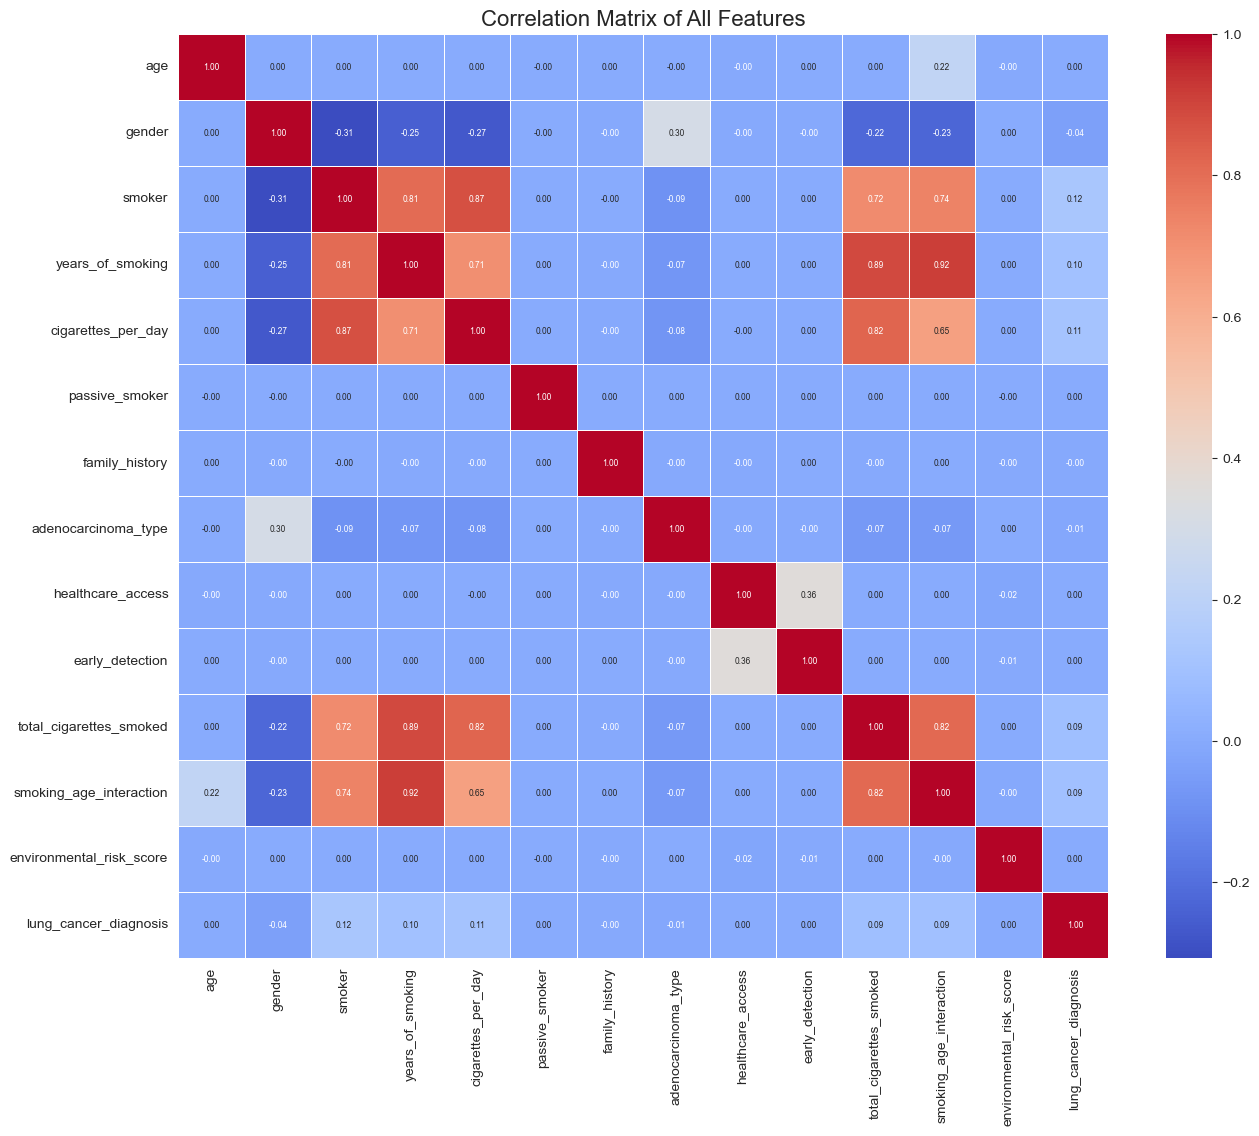

In [26]:
# @title Encoding Categorical Features and Scaling Numerical Features
# --- Encoding Categorical Features ---
# Encode the target variable (assuming 'Yes'/'No' or similar)
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"Original 'lung_cancer_diagnosis' classes mapped to: {le_target.classes_} -> {le_target.transform(le_target.classes_)}")

# Binary Categorical Features Encoding (Explicit Mapping)
# Manually map binary categorical features to 0 and 1.
binary_cols_map = {
    'gender': {'Male': 0, 'Female': 1},
    'smoker': {'No': 0, 'Yes': 1},
    'passive_smoker': {'No': 0, 'Yes': 1},
    'family_history': {'No': 0, 'Yes': 1},
    'adenocarcinoma_type': {'No': 0, 'Yes': 1},
    'early_detection': {'No': 0, 'Yes': 1}
}

print("\n--- Binary Encoding ---")
for col, mapping in binary_cols_map.items():
    if col in X.columns:
        X[col] = X[col].map(mapping)
        if X[col].isnull().any():
            # Warn if mapping introduced NaNs (e.g., due to unexpected values)
            print(f"Warning: NaNs introduced in column '{col}' during mapping. Check unique values and mapping.")
        print(f"Mapped binary column '{col}'.")

# Ordinal Categorical Features Encoding (Explicit Mapping)
# Manually map ordinal categorical features based on their inherent order.
ordinal_cols_map = {
    'healthcare_access': {'Poor': 0, 'Good': 1}
}

print("\n--- Ordinal Encoding ---")
for col, mapping in ordinal_cols_map.items():
    if col in X.columns:
        # Apply the mapping to the column
        X[col] = X[col].map(mapping)
        if X[col].isnull().any():
            # Warn if mapping introduced NaNs
            print(f"Warning: NaNs introduced in column '{col}' during mapping. Check unique values and mapping.")
        print(f"Mapped ordinal column '{col}'.")

# Multi-Category Nominal Features (One-Hot Encoding)
nominal_cols = ['country', 'developed_or_developing']

# Filter for columns that actually exist in the DataFrame
nominal_cols = [col for col in nominal_cols if col in X.columns]

print("\n--- One-Hot Encoding ---")
if nominal_cols:
    # Apply one-hot encoding
    X_encoded = pd.get_dummies(X, columns=nominal_cols, drop_first=True)
    print(f"Applied One-Hot Encoding to: {nominal_cols}")
else:
    X_encoded = X.copy()
    print("No multi-category nominal columns for One-Hot Encoding.")

print("\nShape after all Encoding:", X_encoded.shape)
print("First 5 rows of encoded features (X_encoded):")
display(X_encoded.head()) # Use display for better formatting

# --- Scaling Numerical Features ---
# Identify numerical columns that need scaling.
numerical_cols = [
    'age', 'years_of_smoking', 'cigarettes_per_day',
    'total_cigarettes_smoked', 'smoking_age_interaction', 'environmental_risk_score'
]

X_scaled = X_encoded.drop(columns=['air_pollution_exposure', 'occupational_exposure', 'indoor_pollution',
                                   'air_pollution_exposure_num', 'occupational_exposure_num', 'indoor_pollution_num'],
                                   errors='ignore')

# Filter for columns that actually exist in the DataFrame after encoding
numerical_cols = [col for col in numerical_cols if col in X_encoded.columns]

print("\n--- Scaling Numerical Features ---")
scaler = StandardScaler()
if numerical_cols:
    X_scaled[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])
    print(f"Applied StandardScaler to: {numerical_cols}")
else:
    X_scaled = X_encoded.copy()
    print("No numerical columns found to scale.")

print("\nFirst 5 rows of scaled features (X_scaled):")
display(X_scaled.head())
print("\nDescriptive Statistics for Scaled Numerical Features:")
if numerical_cols:
    display(X_scaled[numerical_cols].describe())

# --- Correlation Matrix ---
# Create a copy of the scaled features for the correlation matrix
correlation_matrix_df = X_scaled.copy()

# Add the encoded target variable
correlation_matrix_df['lung_cancer_diagnosis'] = y_encoded

# Drop any non-numerical columns that might have been missed in preprocessing
# This is a safe way to ensure the DataFrame only contains numbers
for col in correlation_matrix_df.columns:
    if correlation_matrix_df[col].dtype == 'object':
        correlation_matrix_df = correlation_matrix_df.drop(col, axis=1)

# Now, plot the correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.4, annot_kws={"size": 6})
plt.title('Correlation Matrix of All Features', fontsize=16)
plt.savefig(os.path.join('Image', 'correlation_matrix_of_all_features.png'))
plt.show()

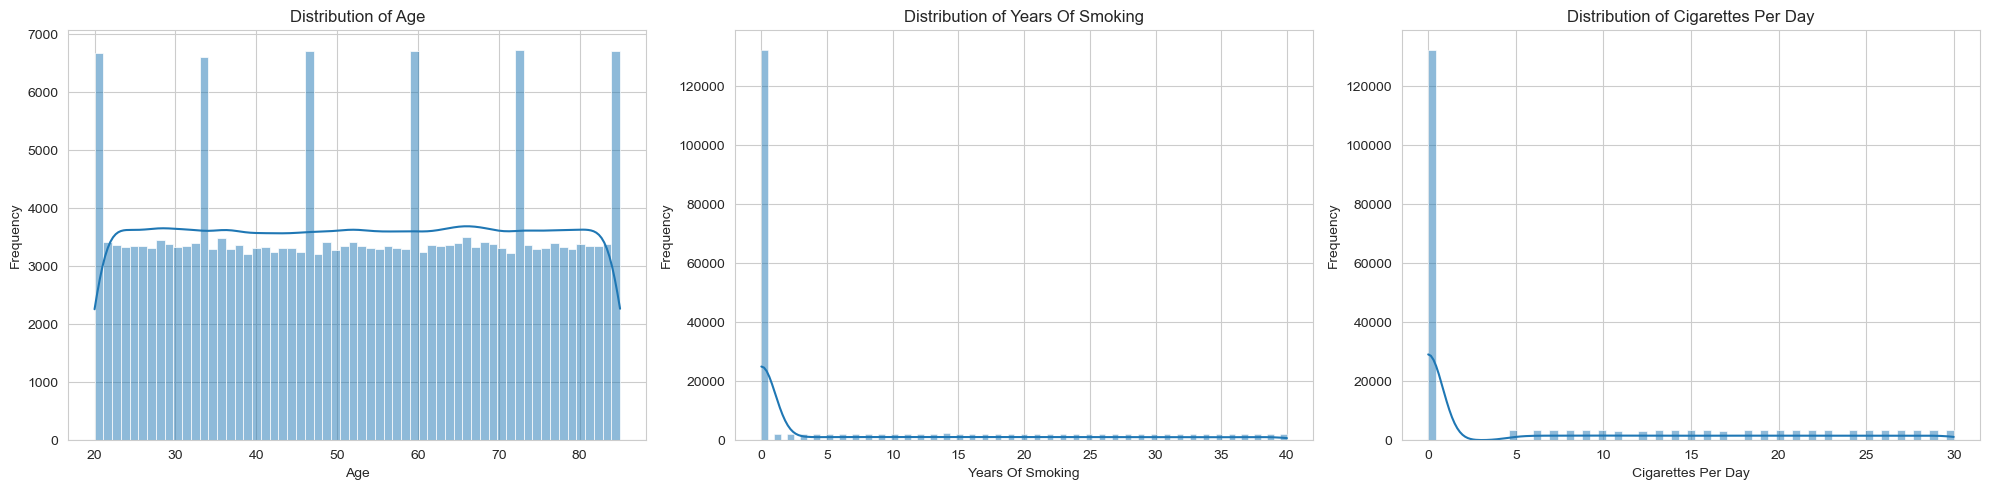

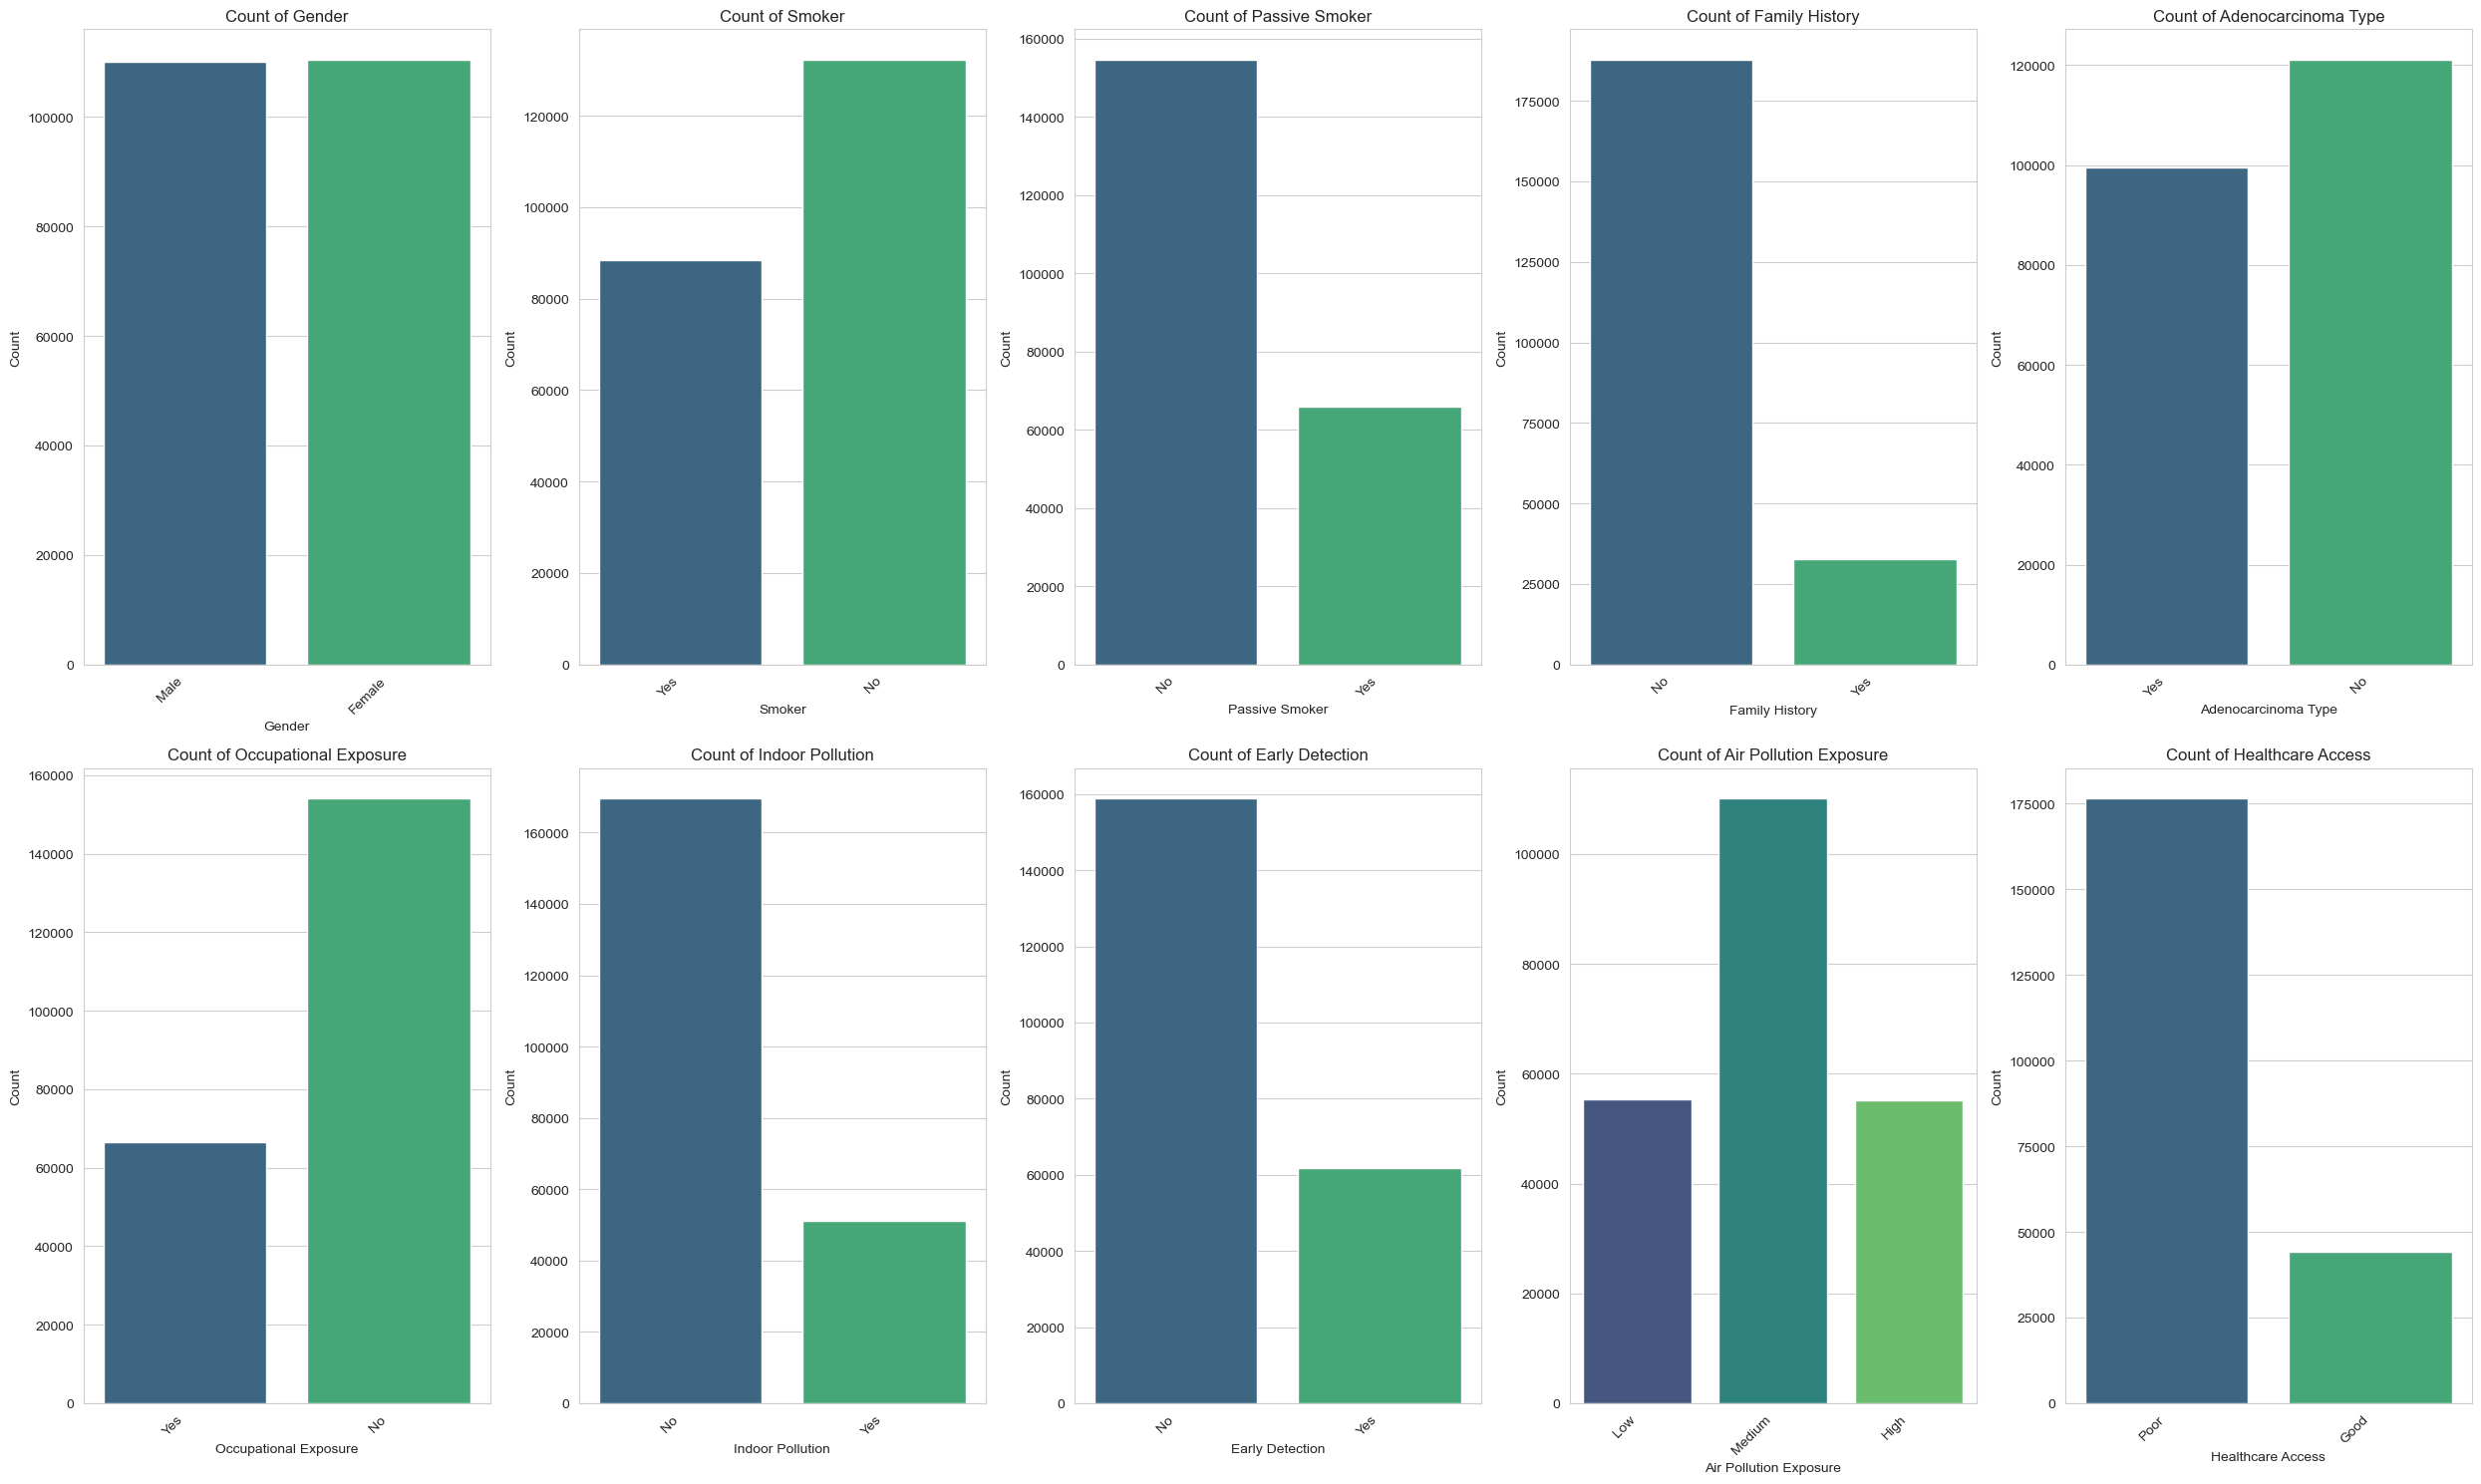

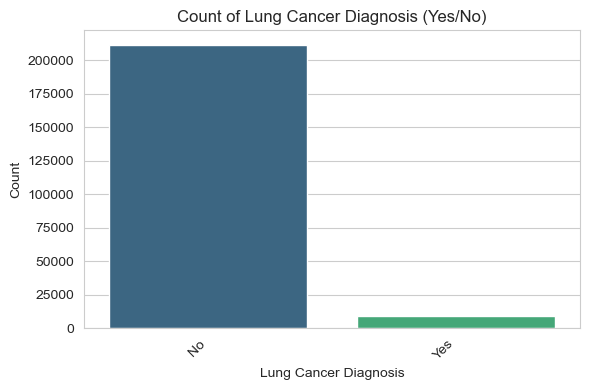

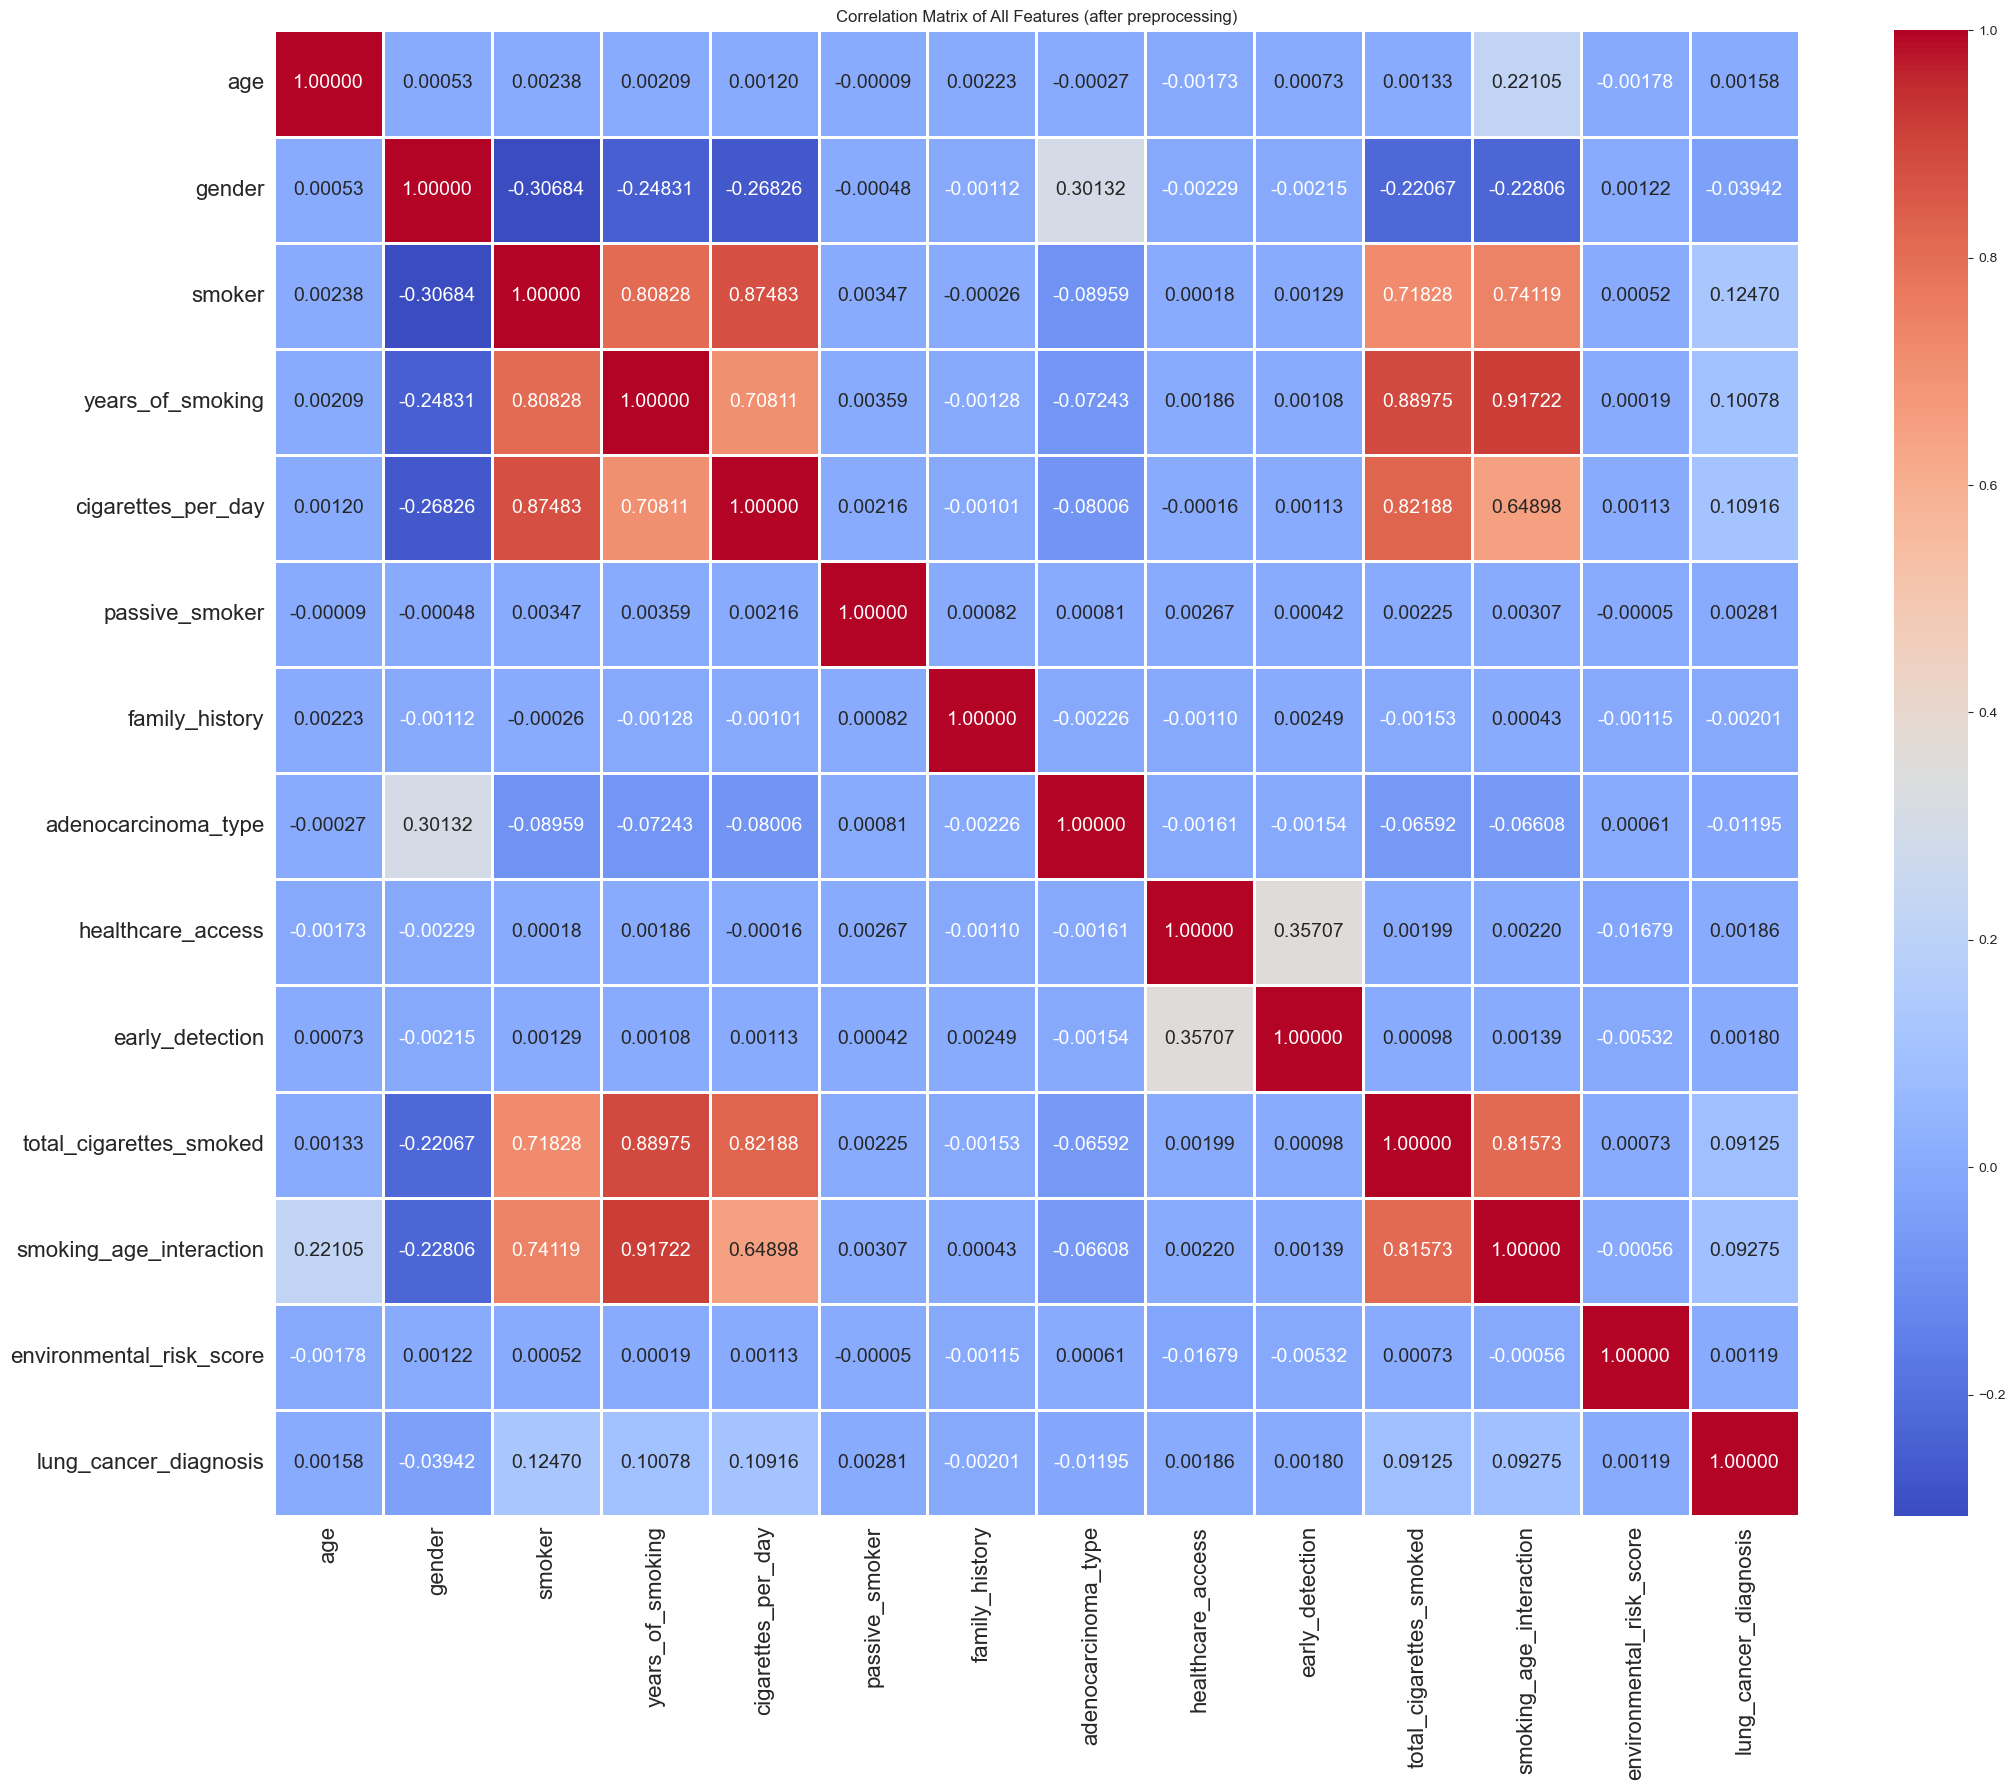

In [48]:
# @title Exploratory Data Analysis (EDA) Plots
print("\n--- Exploratory Data Analysis (EDA) ---")

# Unscaled data for initial EDA (before scaling for model training)
df_eda = df_processed.copy()
df_eda['lung_cancer_diagnosis_encoded'] = y_encoded # Use the encoded target for EDA correlations

# Distribution of Numerical Features
print("\n- Distribution of Numerical Features:")
numerical_cols_for_eda = ['age', 'years_of_smoking', 'cigarettes_per_day']

plt.figure(figsize=(20, 5))
for i, col in enumerate(numerical_cols_for_eda):
    if col in df_eda.columns:
        plt.subplot(1, len(numerical_cols_for_eda), i + 1)
        sns.histplot(df_eda[col], kde=True)
        plt.title(f'Distribution of {col.replace("_", " ").title()}')
        plt.xlabel(col.replace("_", " ").title())
        plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join('Image', 'numerical_features_distribution.png'))
plt.show()


# Count Plots for Key Categorical Features (Original, if available)
print("\n- Count Plots for Key Categorical Features:")
categorical_cols_for_eda = ['gender', 'smoker', 'passive_smoker', 'family_history', 'adenocarcinoma_type', 'occupational_exposure', 'indoor_pollution', 'early_detection', 'air_pollution_exposure', 'healthcare_access']

plt.figure(figsize=(25, 15))

for i, col in enumerate(categorical_cols_for_eda):
    # Use original df for raw categorical values if not encoded yet for clearer visualization
    if col in df.columns:
        plt.subplot(2, 5, i + 1)
        sns.countplot(x=col, data=df, hue=col, palette='viridis', legend=False)
        plt.title(f'Count of {col.replace("_", " ").title()}')
        plt.xlabel(col.replace("_", " ").title())
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(os.path.join('Image', 'categorical_features_count_plots.png'))
plt.show()

# Target Variable Distribution
print("\n- Distribution of Lung Cancer Diagnosis:")
plt.figure(figsize=(6, 4))
sns.countplot(x='lung_cancer_diagnosis', data=df_eda, hue='lung_cancer_diagnosis', palette='viridis', legend=False)
plt.title('Count of Lung Cancer Diagnosis (Yes/No)')
plt.xlabel('Lung Cancer Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join('Image', 'lung_cancer_diagnosis_count.png'))
plt.show()

# Correlation Heatmap (after encoding and scaling, for model insights)
print("\n- Correlation Heatmap of Features:")
plt.figure(figsize=(22, 18))

# Include the encoded target variable in the correlation matrix for insight
correlation_matrix_df = X_scaled.copy()
correlation_matrix_df['lung_cancer_diagnosis'] = y_encoded

sns.heatmap(correlation_matrix_df.corr(), annot=True, cmap='coolwarm', fmt=".5f", linewidths=1, annot_kws={"size": 14})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Correlation Matrix of All Features (after preprocessing)')
plt.tight_layout()
plt.savefig(os.path.join('Image', 'correlation_matrix_of_all_features.png'))
plt.show()

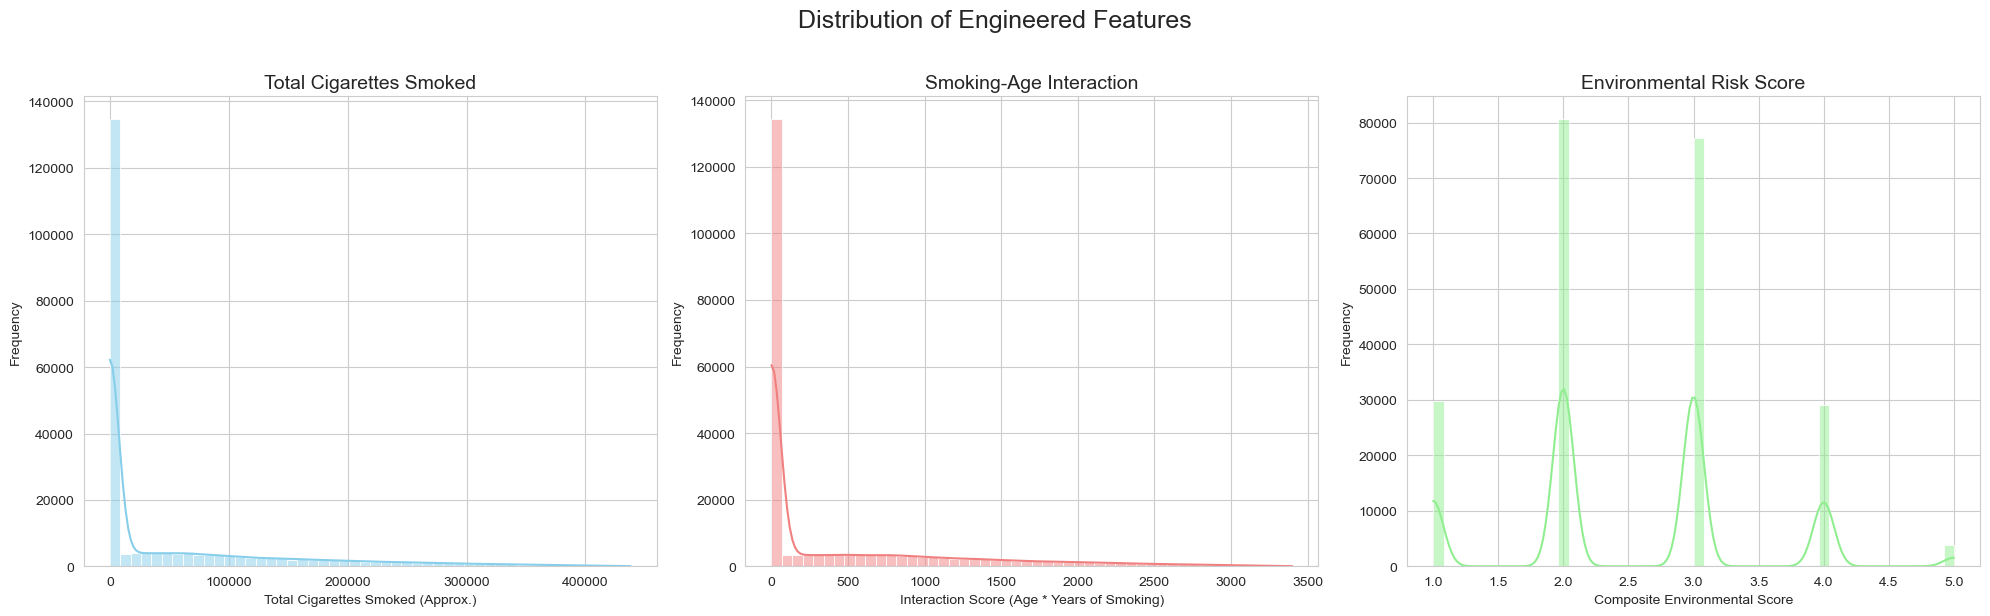

In [ ]:
# --- Plotting the Engineered Features ---
# Create a figure with a subplot for each new feature.
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribution of Engineered Features', fontsize=18, y=1.02)
sns.set_style("whitegrid")

# Plot 1: Distribution of 'total_cigarettes_smoked'
sns.histplot(df_processed['total_cigarettes_smoked'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Total Cigarettes Smoked', fontsize=14)
axes[0].set_xlabel('Total Cigarettes Smoked (Approx.)')
axes[0].set_ylabel('Frequency')

# Plot 2: Distribution of 'smoking_age_interaction'
sns.histplot(df_processed['smoking_age_interaction'], bins=50, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Smoking-Age Interaction', fontsize=14)
axes[1].set_xlabel('Interaction Score (Age * Years of Smoking)')
axes[1].set_ylabel('Frequency')

# Plot 3: Distribution of 'environmental_risk_score'
sns.histplot(df_processed['environmental_risk_score'], bins=50, kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('Environmental Risk Score', fontsize=14)
axes[2].set_xlabel('Composite Environmental Score')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join('Image', 'engineered_features_distribution.png'), bbox_inches='tight')
plt.show()

In [29]:
# @title Train/Test Split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nShape of X_train: {X_train.shape}")
print(f"y_train class distribution:\n{pd.Series(y_train).value_counts()}")

In [30]:
# This dictionary stores different classification model instances to be trained and evaluated.
# Model Definitions
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(n_jobs=-1, random_state=42, max_iter=1000),
    'Linear SVM': LinearSVC(random_state=42, dual=False),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

In [31]:
# Evaluate all models on each resampled dataset
def evaluate_all_models_on_resample(X_resampled, y_resampled, X_test, y_test, sampler_name):
    print(f"\n--- Evaluating all models on {sampler_name} resampled data ---")
    # Check if y_resampled contains at least two classes
    if len(set(y_resampled)) < 2:
        print(f"Skipping model training for {sampler_name}: Only one class present in resampled data ({set(y_resampled)}).")
        return
    for name, model in models.items():
        print(f"\n{name} on {sampler_name}:")
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        recall = recall_score(y_test, y_pred, pos_label=1)
        print(f"Accuracy: {acc:.4f}")
        print(f"F1-score (Cancer): {f1:.4f}")
        print(f"Recall (Cancer): {recall:.4f}")
        print(classification_report(y_test, y_pred))

for sampler, sampler_name in [
    (SMOTE(random_state=42), 'SMOTE'),
    (ADASYN(random_state=42), 'ADASYN'),
    (RandomOverSampler(random_state=42), 'RandomOverSampler'),
    (EditedNearestNeighbours(sampling_strategy='all'), 'EditedNearestNeighbours (ENN)'),
    (SMOTEENN(random_state=42), 'SMOTEENN')
]:
    print(f"\n--- Applying {sampler_name} ---")
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    print(f"Resampled shape: {X_resampled.shape}")
    print(f"Resampled class counts: {Counter(y_resampled)}")
    evaluate_all_models_on_resample(X_resampled, y_resampled, X_test, y_test, sampler_name)

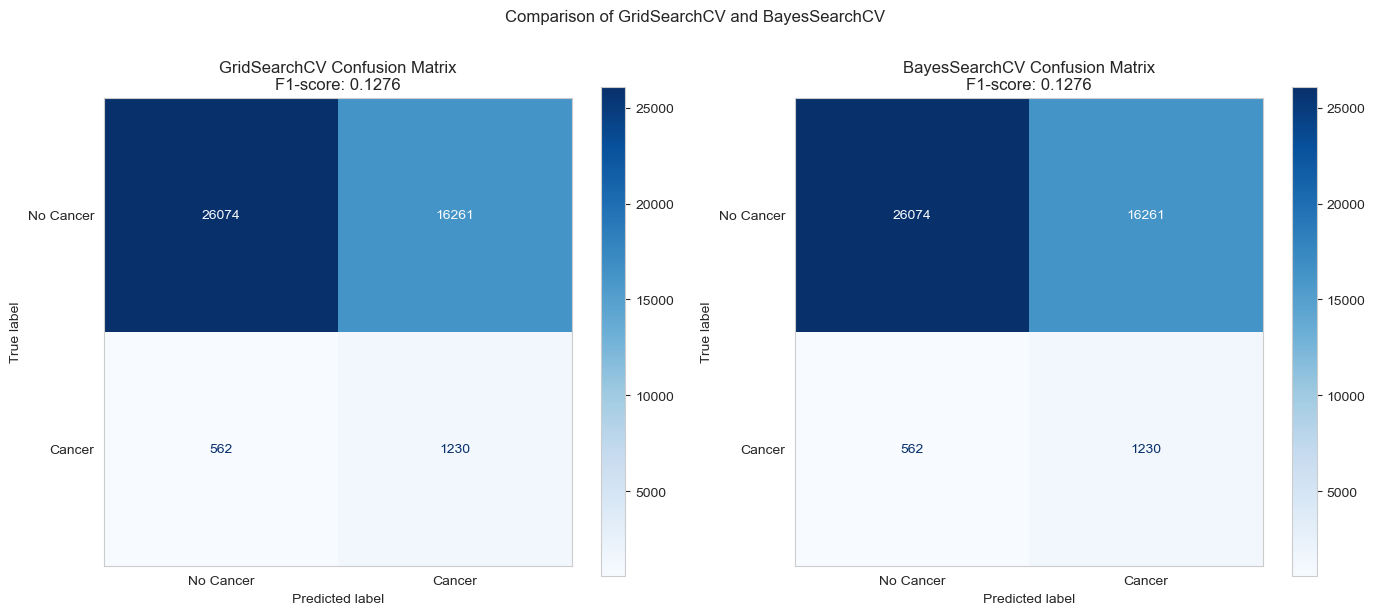

In [32]:
# --- Compare GridSearchCV vs. Bayesian Optimization ---
print("\n--- Comparing GridSearchCV vs. Bayesian Optimization for Logistic Regression ---")

param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
lr_model = LogisticRegression(random_state=42, solver='liblinear')

# Use SMOTEENN for this comparison as it was your best result
smoteenn_sampler = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn_sampler.fit_resample(X_train, y_train)

# 1. GridSearchCV
start_time_grid = time.time()
grid_search = GridSearchCV(lr_model, param_grid_lr, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)
grid_time = time.time() - start_time_grid

print(f"\nGridSearchCV Best parameters: {grid_search.best_params_}")
print(f"GridSearchCV Best F1-score: {grid_search.best_score_:.4f}")
print(f"GridSearchCV Time taken: {grid_time:.2f} seconds")

# 2. Bayesian Optimization with BayesSearchCV
start_time_bayes = time.time()
param_space_lr = {'C': Real(0.001, 1000, prior='log-uniform')}
bayes_search = BayesSearchCV(lr_model, param_space_lr, n_iter=30, cv=5, scoring='f1', n_jobs=-1, verbose=1, random_state=42)
bayes_search.fit(X_train_resampled, y_train_resampled)
bayes_time = time.time() - start_time_bayes

print(f"\nBayesSearchCV Best parameters: {bayes_search.best_params_}")
print(f"BayesSearchCV Best F1-score: {bayes_search.best_score_:.4f}")
print(f"BayesSearchCV Time taken: {bayes_time:.2f} seconds")

# Evaluate the best model from Bayesian Optimization on the test set
best_bayes_model = bayes_search.best_estimator_
y_pred_bayes = best_bayes_model.predict(X_test)
print("\nFinal Evaluation of BayesSearchCV Best Model:")
print("Classification Report:\n", classification_report(y_test, y_pred_bayes))

# Compare Confusion Matrices for visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

cm_grid = confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test))
disp_grid = ConfusionMatrixDisplay(confusion_matrix=cm_grid, display_labels=['No Cancer', 'Cancer'])
disp_grid.plot(cmap='Blues', ax=ax1)
ax1.set_title(f"GridSearchCV Confusion Matrix\nF1-score: {f1_score(y_test, grid_search.best_estimator_.predict(X_test)):.4f}")
ax1.grid(False)

cm_bayes = confusion_matrix(y_test, y_pred_bayes)
disp_bayes = ConfusionMatrixDisplay(confusion_matrix=cm_bayes, display_labels=['No Cancer', 'Cancer'])
disp_bayes.plot(cmap='Blues', ax=ax2)
ax2.set_title(f"BayesSearchCV Confusion Matrix\nF1-score: {f1_score(y_test, y_pred_bayes):.4f}")
ax2.grid(False)

plt.suptitle("Comparison of GridSearchCV and BayesSearchCV")
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig(os.path.join('Image', 'tuning_comparison.png'))
plt.show()


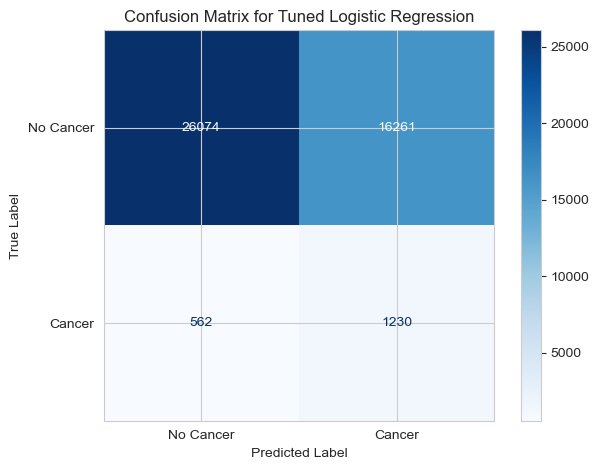

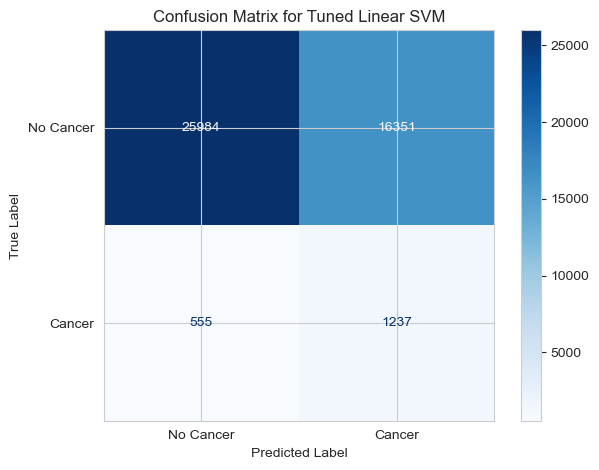

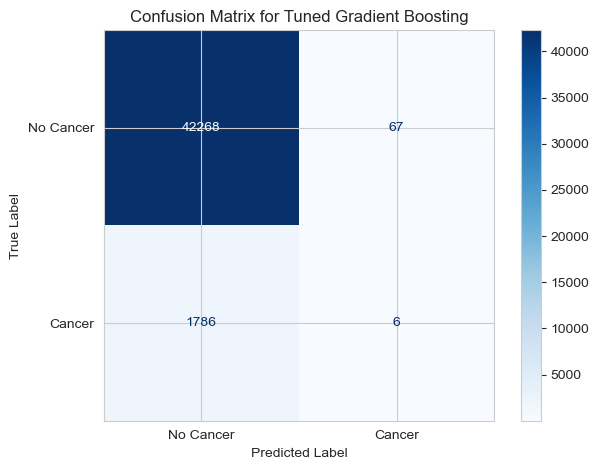

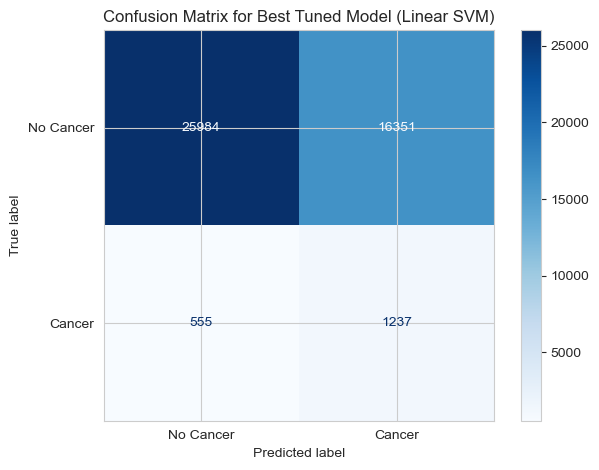

In [ ]:
# --- Hyperparameter Tuning with GridSearchCV on Models ---
print("\n--- Starting Hyperparameter Tuning with GridSearchCV on Models ---")

# Using SMOTEENN, as it was a strong performer in your previous run.
smoteenn_sampler = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn_sampler.fit_resample(X_train, y_train)

print(f"Shape of X_train after SMOTEENN: {X_train_resampled.shape}")
print("y_train class distribution SMOTEENN:")
print(f"Original class counts: {Counter(y_train)}")
print(f"Resampled class counts: {Counter(y_train_resampled)}\n")

# This dictionary replaces the manual comparison with a comprehensive search
# across multiple models.
models_to_tune = {
    'Logistic Regression': (LogisticRegression(solver='liblinear', random_state=42),
                            {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    'Linear SVM': (LinearSVC(random_state=42),
                    {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42),
                          {'n_estimators': [50, 100, 200],
                           'learning_rate': [0.01, 0.1, 0.2],
                           'max_depth': [3, 5, 7]})
}

tuning_results = {}
best_f1_score = -1 # Use a negative value to ensure the first model is always the best so far
best_model_name = ""

# This loop iterates through all three models, tuning and evaluating each one
for model_name, (model, param_grid) in models_to_tune.items():
    print(f"\nSearching for best hyperparameters for {model_name}...")
    start_time = time.time()
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    end_time = time.time()
    
    y_pred = grid_search.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    
    # Store all results for later reference
    tuning_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_f1_score_train': grid_search.best_score_,
        'f1_score_test': test_f1,
        'time_taken': end_time - start_time
    }
    
    print(f"--- Results for {model_name} ---")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"F1-score on test data: {test_f1:.4f}")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    
    # Check if this is the overall best model found so far
    if test_f1 > best_f1_score:
        best_f1_score = test_f1
        best_model_name = model_name

    # Plot and save Confusion Matrix for the current model
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer', 'Cancer'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for Tuned {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(os.path.join('Image', f'Tuned_{model_name}_Confusion_Matrix.png'))
    plt.show()

# --- Final Evaluation and Summary ---
print(f"\n--- Hyperparameter Tuning Summary ---")
for model_name, results in tuning_results.items():
    print(f"\nModel: {model_name}")
    print(f"  Best Parameters: {results['best_params']}")
    print(f"  Best F1-score (Cross-Validation): {results['best_f1_score_train']:.4f}")
    print(f"  F1-score on Test Data: {results['f1_score_test']:.4f}")
    print(f"  Time Taken: {results['time_taken']:.2f} seconds")

# --- Final Evaluation of the Overall Best Model ---
print(f"\n--- Final Evaluation of the Overall Best Model: {best_model_name} ---")
final_best_model = tuning_results[best_model_name]['best_estimator']
y_pred_best = final_best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred_best))

# Plot and save Confusion Matrix for the overall best model
cm_best = confusion_matrix(y_test, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['No Cancer', 'Cancer'])
disp_best.plot(cmap='Blues')
plt.title(f'Confusion Matrix for Best Tuned Model ({best_model_name})')
plt.tight_layout()
plt.savefig(os.path.join('Image', f'Best_Tuned_Model_Final_Confusion_Matrix_{best_model_name}.png'))
plt.show()

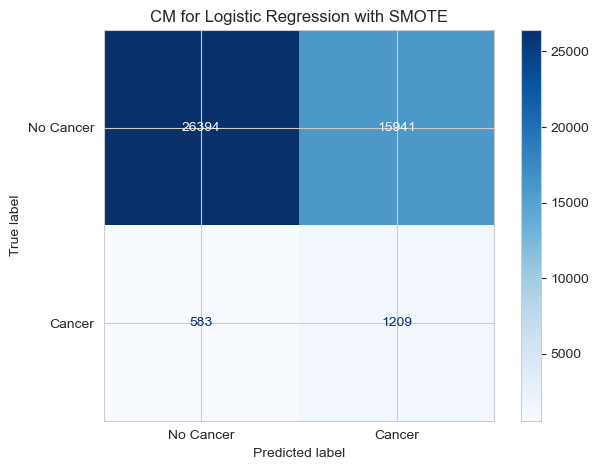

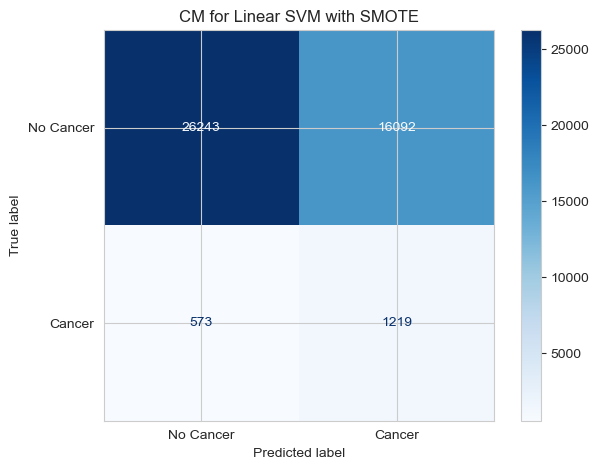

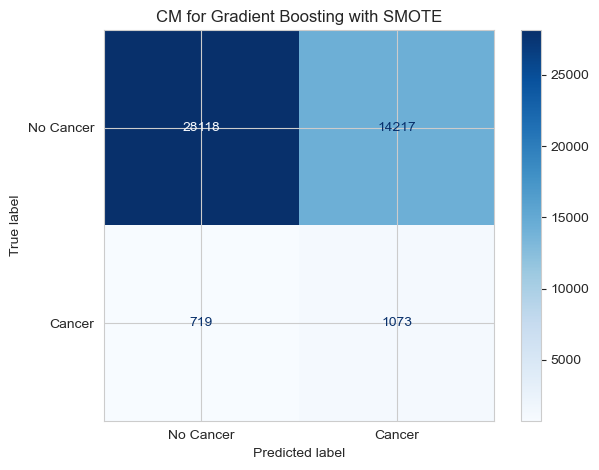

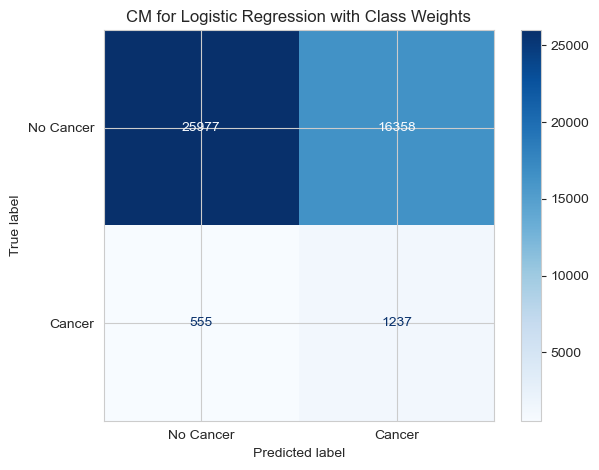

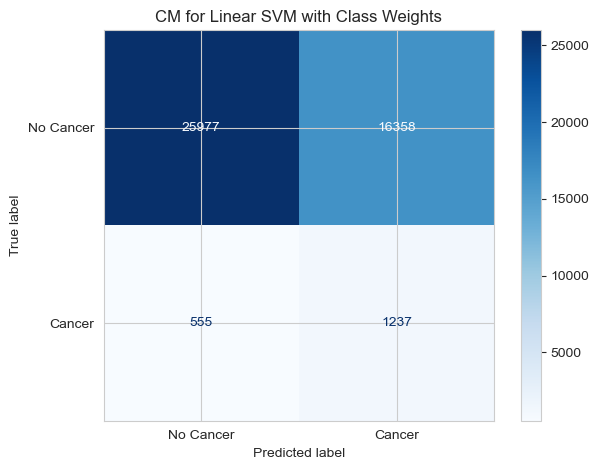

In [34]:
# --- Assume X_train, y_train, X_test, y_test are already defined ---

# --- Define Models and Parameter Grids ---
# We will use pipelines to handle scaling and model training together, which is a best practice.
# This ensures scaling is only applied to the training data.
models_to_tune = {
    'Logistic Regression': (LogisticRegression(solver='liblinear', random_state=42),
                            {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    'Linear SVM': (LinearSVC(random_state=42),
                   {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42),
                          {'classifier__n_estimators': [50, 100, 200],
                           'classifier__learning_rate': [0.01, 0.1, 0.2],
                           'classifier__max_depth': [3, 5, 7]})
}


# --- Experiment 1: Hyperparameter Tuning with SMOTE Resampling ---
print("\n--- Experiment 1: Hyperparameter Tuning with SMOTE Resampling ---")
smote_sampler = SMOTE(random_state=42)

for model_name, (model, param_grid) in models_to_tune.items():
    # Use imblearn's pipeline for resampling within cross-validation
    pipeline = Pipeline([
        ('resampler', smote_sampler),
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    print(f"\nSearching for best hyperparameters for {model_name} with SMOTE...")
    start_time = time.time()
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train) # Note: We pass the original training data here
    
    end_time = time.time()
    
    y_pred = grid_search.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    
    print(f"--- Results for {model_name} with SMOTE ---")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1-score (Cross-Validation): {grid_search.best_score_:.4f}")
    print(f"F1-score on test data: {test_f1:.4f}")
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Plot and save Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer', 'Cancer'])
    disp.plot(cmap='Blues')
    plt.title(f'CM for {model_name} with SMOTE')
    plt.tight_layout()
    plt.savefig(os.path.join('Image', f'{model_name}_SMOTE_CM.png'))
    plt.show()


# --- Experiment 2: Hyperparameter Tuning with Class Weights (No Resampling) ---
print("\n--- Experiment 2: Hyperparameter Tuning with Class Weights (No Resampling) ---")

# Models that support class_weight
models_with_weights = {
    'Logistic Regression': (LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'),
                            {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    'Linear SVM': (LinearSVC(random_state=42, class_weight='balanced'),
                   {'C': [0.001, 0.01, 0.1, 1, 10, 100]})
}

for model_name, (model, param_grid) in models_with_weights.items():
    # Use sklearn's standard pipeline since no resampling is needed
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    print(f"\nSearching for best hyperparameters for {model_name} with Class Weights...")
    start_time = time.time()
    
    grid_search = GridSearchCV(pipeline, {'classifier__' + k: v for k, v in param_grid.items()}, cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train) # Use original training data
    
    end_time = time.time()
    
    y_pred = grid_search.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)

    print(f"--- Results for {model_name} with Class Weights ---")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best F1-score (Cross-Validation): {grid_search.best_score_:.4f}")
    print(f"F1-score on test data: {test_f1:.4f}")
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    
    # Plot and save Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer', 'Cancer'])
    disp.plot(cmap='Blues')
    plt.title(f'CM for {model_name} with Class Weights')
    plt.tight_layout()
    plt.savefig(os.path.join('Image', f'{model_name}_Class_Weights_CM.png'))
    plt.show()

# Gradient Boosting does not have a native class_weight parameter. It's better to
# use the SMOTE approach for it or a different boosting library like XGBoost or LightGBM,
# which has a scale_pos_weight parameter.

print("\n--- All experiments concluded. Compare the results from the plots and printouts. ---")

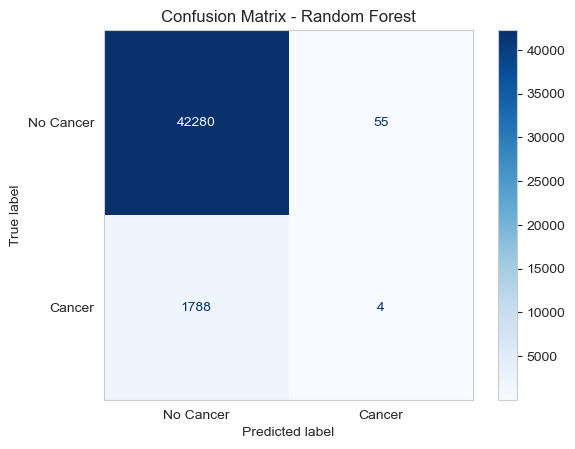

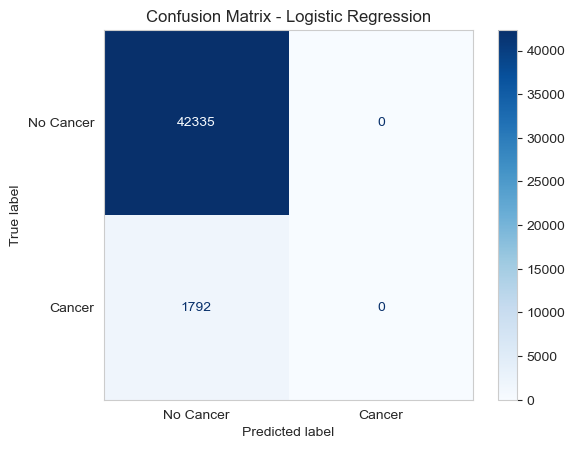

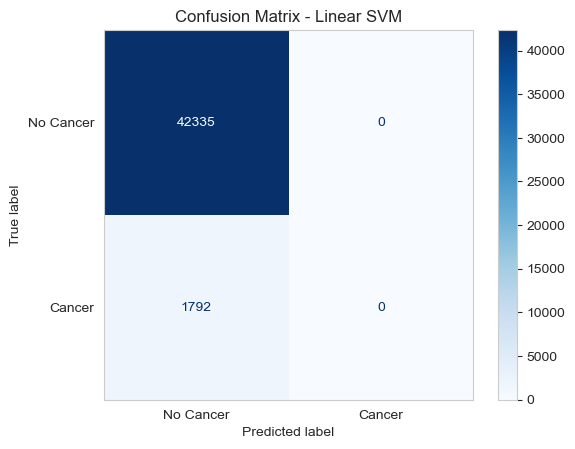

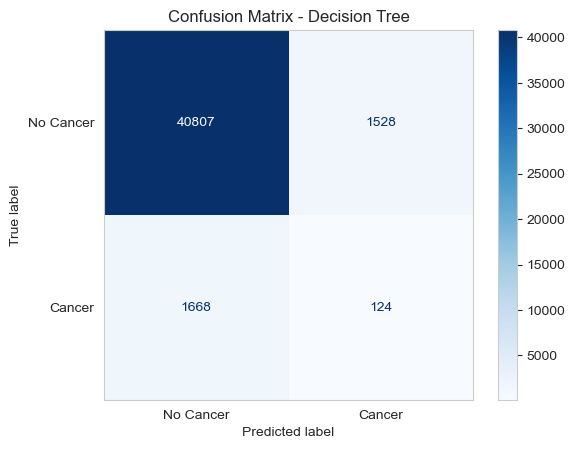

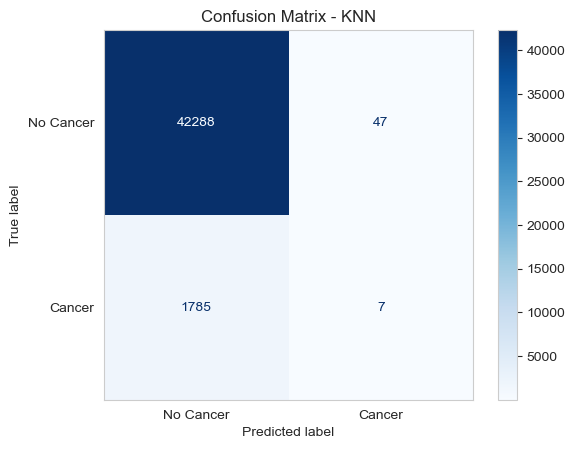

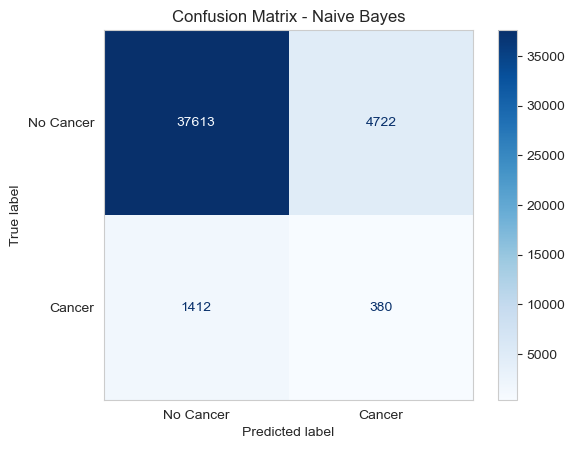

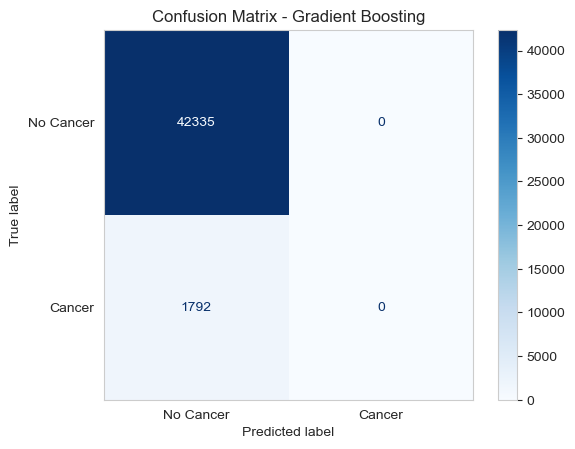

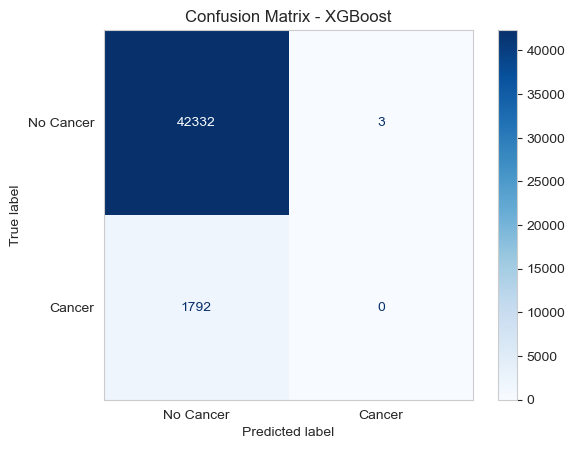

In [35]:
# Model Training & Evaluation
accuracy_results = {}
f1_results = {}

def train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer', 'Cancer'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.grid(False)
    plt.savefig(os.path.join('Image', f'{name}_Confusion_Matrix.png'), bbox_inches='tight')
    plt.show()
    return acc, f1

for name, model in models.items():
    try:
        acc, f1 = train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test)
        accuracy_results[name] = acc
        f1_results[name] = f1
    except Exception as e:
        print(f"Skipping model '{name}' due to error: {e}")
        accuracy_results[name] = 0.0
        f1_results[name] = 0.0

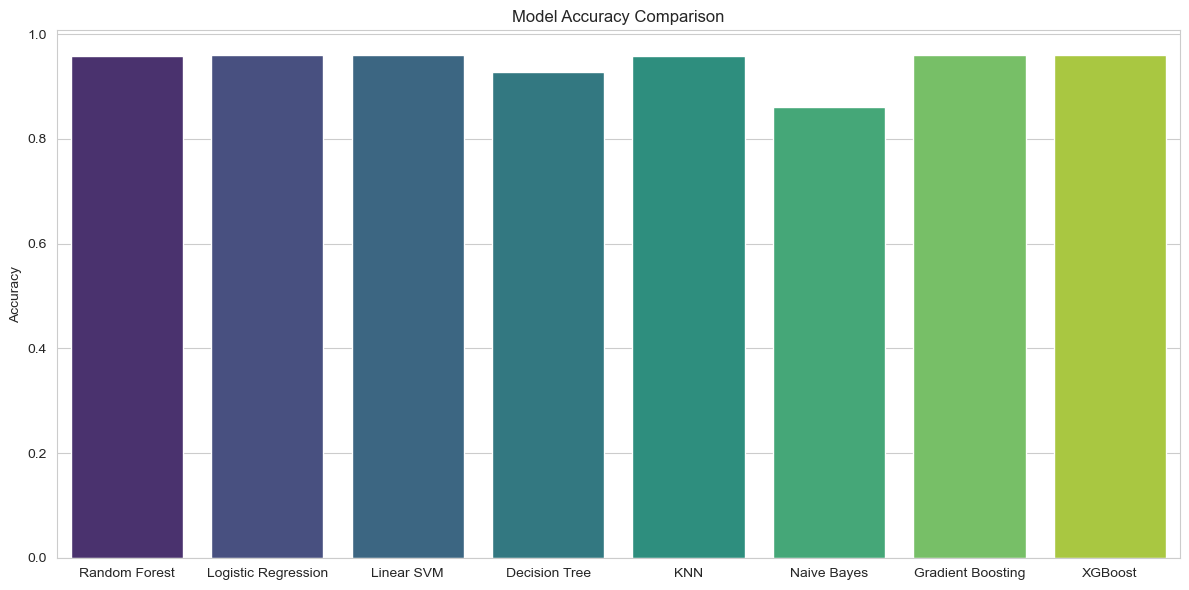

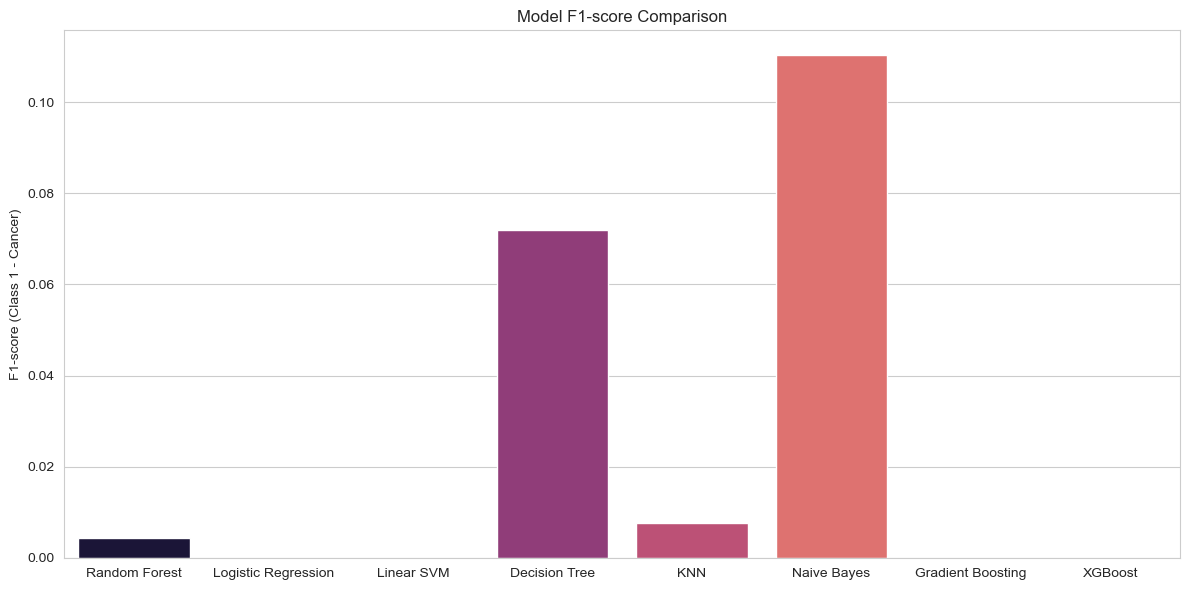

In [36]:
# Model Comparison Plots
plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracy_results.keys()), y=list(accuracy_results.values()), palette='viridis')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.tight_layout()
plt.savefig(os.path.join('Image', 'Accuracy_Comparison_Plot.png'), bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=list(f1_results.keys()), y=list(f1_results.values()), palette='magma')
plt.ylabel('F1-score (Class 1 - Cancer)')
plt.title('Model F1-score Comparison')
plt.tight_layout()
plt.savefig(os.path.join('Image', 'F1_Score_Comparison_Plot.png'), bbox_inches='tight')
plt.show()

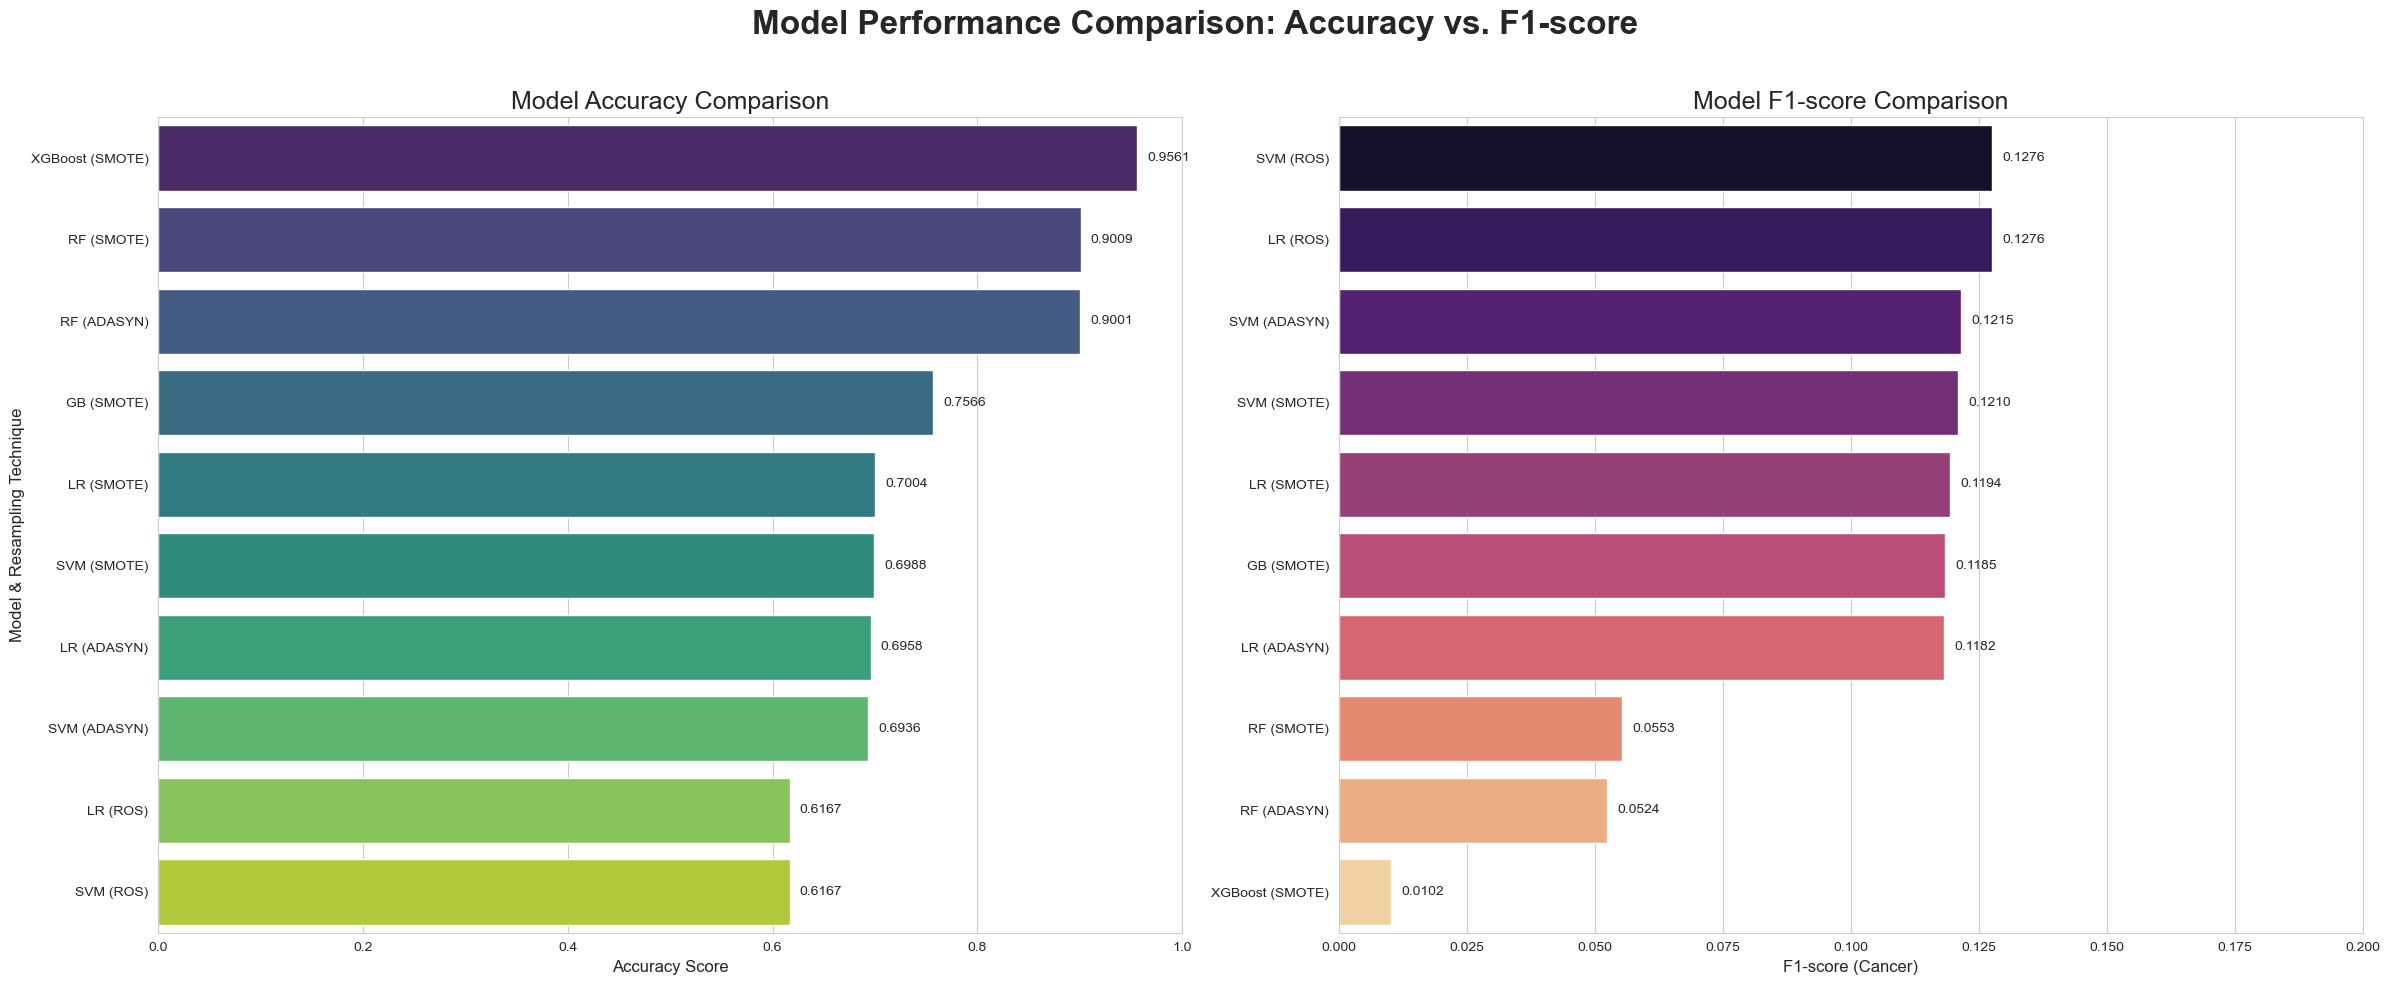

In [37]:
results_data = {
    'Model': [
        'RF', 'LR', 'SVM', 'GB', 'XGBoost',
        'RF', 'LR', 'SVM',
        'LR', 'SVM'
    ],
    'Resampling Technique': [
        'SMOTE', 'SMOTE', 'SMOTE', 'SMOTE', 'SMOTE',
        'ADASYN', 'ADASYN', 'ADASYN',
        'ROS', 'ROS'
    ],
    'Accuracy': [
        0.9009, 0.7004, 0.6988, 0.7566, 0.9561,
        0.9001, 0.6958, 0.6936,
        0.6167, 0.6167
    ],
    'F1-score (Cancer)': [
        0.0553, 0.1194, 0.1210, 0.1185, 0.0102,
        0.0524, 0.1182, 0.1215,
        0.1276, 0.1276
    ]
}

# Create a pandas DataFrame from the data
df_results = pd.DataFrame(results_data)

# Combine Model and Resampling Technique for a single, unique identifier on the y-axis
df_results['Model_Technique'] = df_results['Model'] + ' (' + df_results['Resampling Technique'] + ')'

# --- Plotting the Data ---
# Create a figure with two subplots for Accuracy and F1-score.
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('Model Performance Comparison: Accuracy vs. F1-score', fontsize=24, fontweight='bold')
sns.set_style("whitegrid")

# Plot 1: Accuracy Comparison
sns.barplot(
    x='Accuracy',
    y='Model_Technique',
    data=df_results.sort_values(by='Accuracy', ascending=False),
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Model Accuracy Comparison', fontsize=18)
axes[0].set_xlabel('Accuracy Score', fontsize=12)
axes[0].set_ylabel('Model & Resampling Technique', fontsize=12)
axes[0].set_xlim(0, 1.0)
axes[0].tick_params(axis='y', labelsize=10)
# Add exact scores to the bars for easy reading
for index, value in enumerate(df_results.sort_values(by='Accuracy', ascending=False)['Accuracy']):
    axes[0].text(value + 0.01, index, f"{value:.4f}", ha='left', va='center', fontsize=10)

# Plot 2: F1-score Comparison
sns.barplot(
    x='F1-score (Cancer)',
    y='Model_Technique',
    data=df_results.sort_values(by='F1-score (Cancer)', ascending=False),
    ax=axes[1],
    palette='magma'
)
axes[1].set_title('Model F1-score Comparison', fontsize=18)
axes[1].set_xlabel('F1-score (Cancer)', fontsize=12)
axes[1].set_ylabel('') # No need for a y-label on the second plot
axes[1].set_xlim(0, 0.2)
axes[1].tick_params(axis='y', labelsize=10)
# Add exact scores to the bars for easy reading
for index, value in enumerate(df_results.sort_values(by='F1-score (Cancer)', ascending=False)['F1-score (Cancer)']):
    axes[1].text(value + 0.002, index, f"{value:.4f}", ha='left', va='center', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join('Image', 'model_performance_comparison_plots.png'), bbox_inches='tight')
plt.show()


In [38]:
# @title Save the Best Model and Preprocessor
# This section has been added to prepare your model for a back-end service.
# It saves the trained model and the preprocessor objects to disk.
import pickle

print("\n--- Saving the Best Model and Preprocessor ---")

# Define the directory to save the model artifacts
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

try:
    # Save the trained StandardScaler object
    scaler_filename = os.path.join(model_dir, 'scaler.pkl')
    with open(scaler_filename, 'wb') as file:
        pickle.dump(scaler, file)
    print(f"✅ Scaler saved to {scaler_filename}")

    # Save the trained LabelEncoder for the target variable
    le_target_filename = os.path.join(model_dir, 'label_encoder.pkl')
    with open(le_target_filename, 'wb') as file:
        pickle.dump(le_target, file)
    print(f"✅ Label Encoder saved to {le_target_filename}")

    # Save the best-performing model from the grid search
    model_filename = os.path.join(model_dir, 'best_model.pkl')
    with open(model_filename, 'wb') as file:
        pickle.dump(best_model, file)
    print(f"✅ Best model saved to {model_filename}")

except Exception as e:
    print(f"❌ Error occurred while saving model artifacts: {e}")

In [39]:
# End Logging
end_time = time.time()
total_time = end_time - start_time
print(f"\n--- Total execution time: {total_time:.2f} seconds ---")
if 'logger' in globals() and logger is not None:
    sys.stdout.flush()
    sys.stdout = sys.__stdout__
    logger.close()
print("✅ Logging completed. Output saved to lung_cancer_prediction_output.txt.")